# Feature extraction with gabor filter and laplacian filter

In [16]:
# import libaries
import numpy as np
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
from skimage import morphology
import numpy as np
import glob
import os
import cv2

## Data storing object for training and testing dataset: Plam_Graph
Chưa được sử dụng trong đoạn code vì mới chỉ test với 1 hình ảnh

## Generate gabor filter

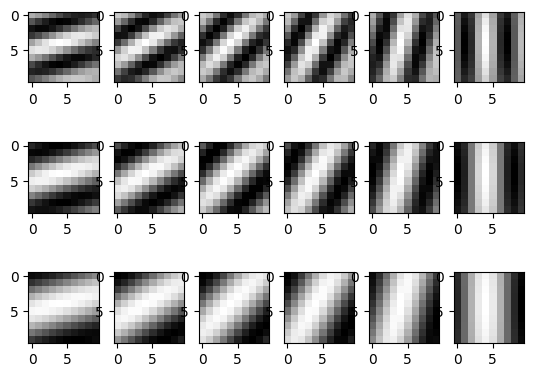

In [17]:
class Gabor():
    def __init__(self, R, C, n_orientation, scale):
        self.R = R
        self.C = C
        self.n_orientation = n_orientation
        self.scale = scale
        self.orientation = np.array([ (u * np.pi / n_orientation) for u in range (1, n_orientation + 1)])
        self.gabor_filters_sets = [gabor_wavelet(R, C, u, scale, n_orientation) for u in range(1, n_orientation + 1)]

    
    # filter image through gabor filter
    def filtering(self, img):
        graphs = np.array([cv2.filter2D(img, -1, np.real(gw)) for gw in self.gabor_filters_sets])
        return graphs
    
    def plot_filters(self, n_scale):
        gabor_filters = []
        fig = plt.figure()
        for v in range (1, n_scale + 1):
            for u in range(1, self.n_orientation + 1):
                gw = gabor_wavelet(self.R, self.C, u, v , self.n_orientation)
                fig.add_subplot(n_scale, self.n_orientation, self.n_orientation * (v- 1) + u)
                plt.imshow(np.real(gw), cmap='gray')
        plt.show()

    

def gabor_wavelet(rows, cols, orientation, scale, n_orientation):
    kmax = np.pi / 2        # 1.5707963267948966
    f = np.sqrt(2)          # 1.4142135623730951 
    delt2 = (2 * np.pi) ** 2
    k = (kmax / (f ** scale)) * np.exp(1j * orientation * np.pi / n_orientation / 2)
    kn2 = np.abs(k) ** 2
    gw = np.zeros((rows, cols), np.complex128)

    for m in range(int(-rows / 2) + 1, int(rows / 2) + 1):
        for n in range(int(-cols / 2) + 1, int(cols / 2) + 1):
            t1 = np.exp(-0.5 * kn2 * (m ** 2 + n ** 2) / delt2)
            t2 = np.exp(1j * (np.real(k) * m + np.imag(k) * n))
            t3 = np.exp(-0.5 * delt2)
            gw[int(m + rows / 2 - 1), int(n + cols / 2 - 1)] = (kn2 / delt2) * t1 * (t2 - t3)

    return gw


n_orientation = 6
scale = 2
GA = Gabor(10, 10, n_orientation, scale)
gabor_filters = GA.gabor_filters_sets
GA.plot_filters(3)


## Laplacian Filter

In [18]:
def Lo_pass_Gaussian_procwess(img, D0):
    rows, cols = img.shape
    mask = np.zeros((rows, cols))
    Locx = np.array(list(range(cols)) * rows).reshape([rows, cols])
    Locy = np.transpose((np.array(list(range(rows)) * cols).reshape([cols,rows])))
    D = np.sqrt((Locx - cols / 2) ** 2 + (Locy - rows / 2 ) ** 2)
    mask = np.exp(-D ** 2 / D0 ** 2 / 2)

    f1 = np.fft.fft2(img)
    f1shift = np.fft.fftshift(f1)
    f1shift = f1shift * mask
    f2shift = np.fft.ifftshift(f1shift)
    img_new = np.fft.ifft2(f2shift)
    img_new = np.abs(img_new)

    return img_new

def LOG_preprocess(img, R0 = 40 , ksize = 5):
    AfterGaussian = np.uint8(Lo_pass_Gaussian_procwess(img, R0))
    processed = cv2.Laplacian(AfterGaussian, -1, ksize=ksize)
    img = cv2.equalizeHist(img)             #????????????????????????????????
    return processed

## Process the image to extract feature


In [19]:
def show_array_img(arr, process):
    plt.figure(figsize=(12, 8))  # Đặt kích thước cửa sổ
    for idx, element in enumerate(arr):
        plt.subplot(3, 4, idx + 1)  # Sắp xếp ảnh trên lưới 3x4 (hoặc thay đổi tuỳ số lượng ảnh)
        plt.imshow(element, cmap='gray')  # Hiển thị ảnh ở dạng grayscale
        plt.title(f"{process} {idx+1}")  # Thêm tiêu đề cho từng ảnh
        plt.axis('off')  # Tắt trục toạ độ

    plt.tight_layout()  # Căn chỉnh lưới để không bị chồng lấn
    plt.show()
    
def process(img):

    # Laplacian process image with above function
    img = LOG_preprocess(img)
    img = img[10:190, 10:190]
    # storing output after gabor filter
    After_gabor = []

    # Gabor process image with the first cell code above
    for i, gw in enumerate(gabor_filters):
        element =  cv2.filter2D(img, -1, np.real(gw))       # filter2d image với mỗi kernel là một gabor filter 
        After_gabor.append(element)


    show_array_img(After_gabor, "Gabor")
    
    
    Two_value = []
    for i, line in enumerate(After_gabor):
        _, TW = cv2.threshold(line, 0 , 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        kernel = np.ones((2,2), np.uint8)
        TW = cv2.erode(TW, kernel)

        Two_value.append(TW)

    show_array_img(Two_value, "threshold")

    con = []


    for i in Two_value:
        conective = morphology.remove_small_objects(i > 0, min_size=40, connectivity=1)
        con.append(conective)
        

    line = (np.sum(con, axis = 0) / len(con))

    show_array_img(con, "Remove small object")


    return line 





# RUN

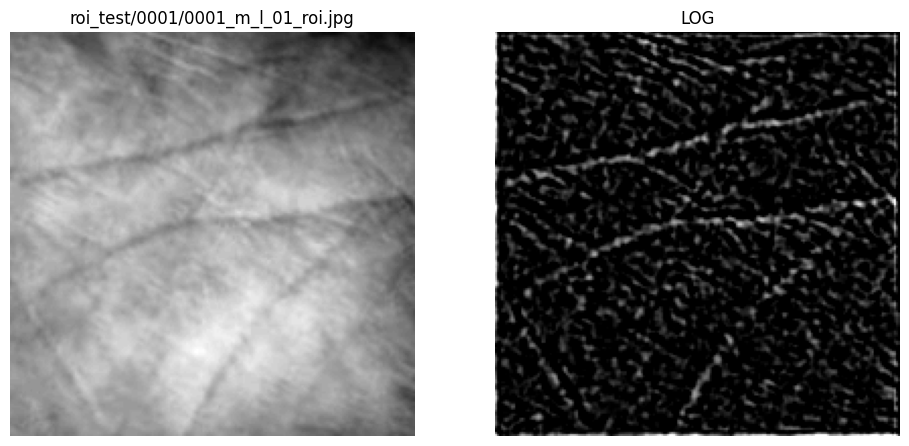

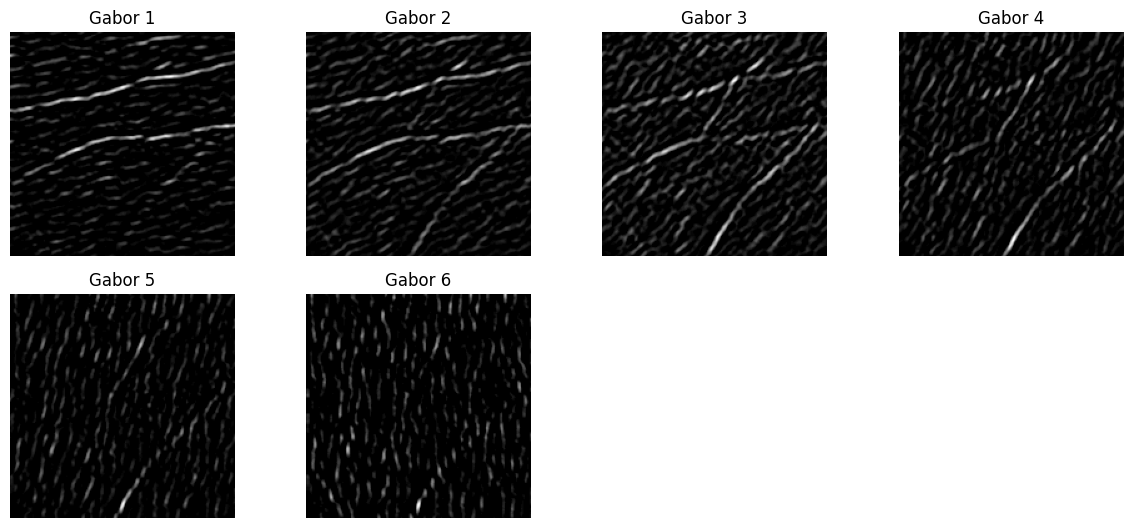

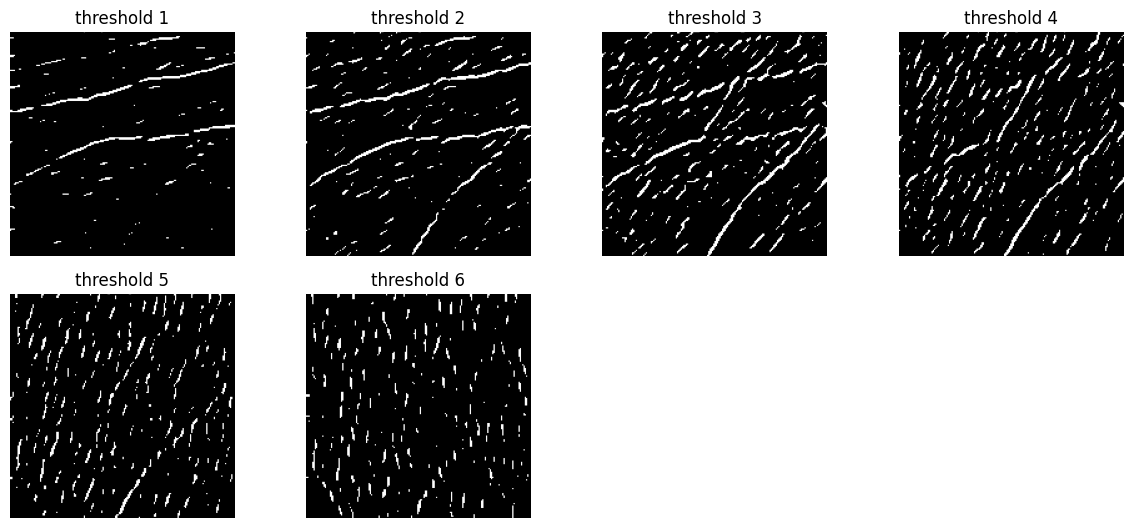

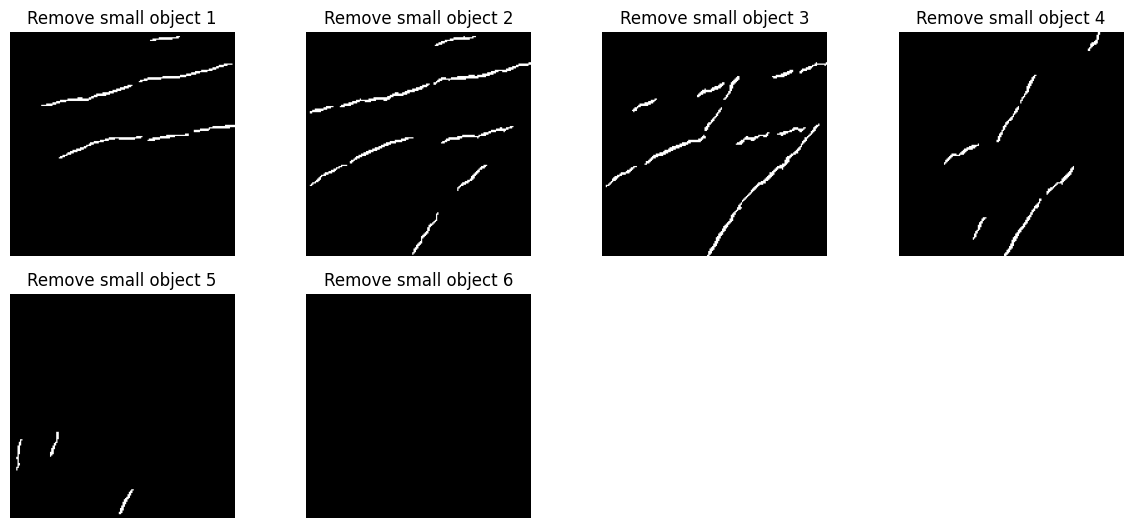

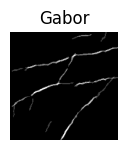

In [20]:
import os
from PIL import Image

path = 'roi_test/0001/0001_m_l_01_roi.jpg'


def edge_detect(path):
    img = Image.open(path)

    # nếu là tay trái thì lật ảnh
    if 'l' in path:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
        
    img = np.array(img)
    img = cv2.resize(img, (200,200), interpolation=cv2.INTER_LINEAR)
    

    
    # add the image to the figure
    plt.figure(figsize=(24,8))
    plt.subplot(141)
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.title(path)

    # GAUSSIAN BLUR (OPTIONAL)
    # img = cv2.GaussianBlur(img, (5, 5), sigmaX=1)

    plt.subplot(142)
    plt.imshow(LOG_preprocess(img), cmap='gray')
    plt.title("LOG")
    plt.axis('off')
    
    edge_img = process(img)

    # fig = plt.figure(dpi=70)
    plt.subplot(143)
    plt.imshow(edge_img, cmap='gray')
    plt.axis('off')
    plt.title('Gabor')
    plt.show()

    return edge_img


edge_img = edge_detect(path)







# HOG

## preprocess

(200, 200)


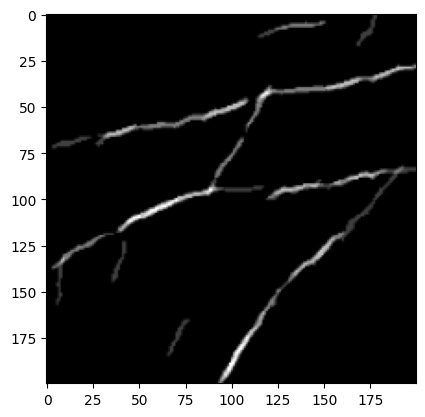

In [21]:
# resize the image (nếu cần thiết)
edge_img = cv2.resize(edge_img, (200,200), interpolation=cv2.INTER_LINEAR)


# chuyển đổi hình ảnh về dạng uint8 với giá trị pixel nằm trong khoảng [0, 256]
edge_img = (edge_img * 255).astype(np.uint8)
plt.imshow(edge_img, cmap='gray')
print(edge_img.shape)



12996


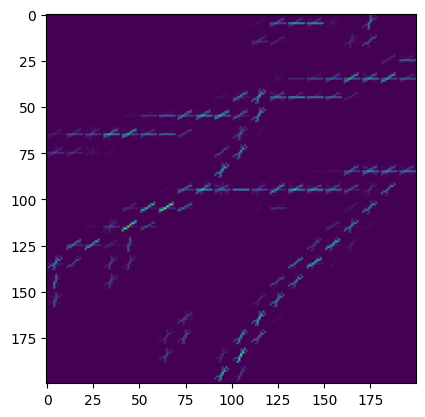

In [22]:

# HOG
from skimage import feature
from skimage import exposure

# HOG với 9 hướng, cell có kích thước 10*10 
(H, hog_img) = feature.hog(edge_img, orientations=9, pixels_per_cell=(10, 10),
            cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", visualize=True)


hogImage = exposure.rescale_intensity(hog_img, out_range=(0, 255))
hogImage = hogImage.astype("uint8")
plt.imshow(hogImage)

# feature description vector
data = H
print(data.size)
